In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

from multiprocess import Pool

import pandas

from cell_utilities import *
from learning_utilities import *

from matplotlib.path import Path

Setting environment for Gordon


No vtk
Cannot import mxnet.


In [2]:
stack = 'MD594'

In [3]:
contour_df, _ = DataManager.load_annotation_v3(stack=stack)
from annotation_utilities import *
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df, stack)

'No object named structures in the file'


Annotation has no structures.


In [4]:
sec = 200

In [5]:
neighbor_info = load_cell_classifier_data(what='neighbor_info', stack=stack, sec=sec, ext='pkl')
neighbors = neighbor_info['neighbors']
radial_indices = neighbor_info['radial_indices']
angular_indices = neighbor_info['angular_indices']

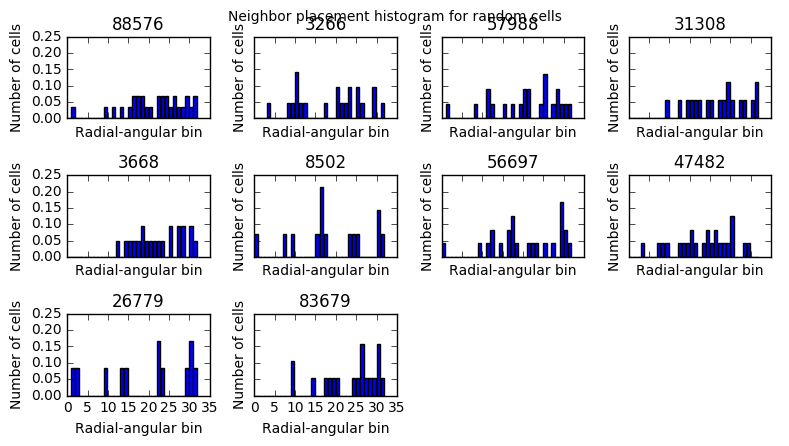

In [6]:
sample_indices = np.random.choice(neighbors.keys(), 10, replace=False)

context_histograms = {cell_ind: np.bincount([n_angular*ri+ai 
                                 for ri, ai in zip(radial_indices[cell_ind], angular_indices[cell_ind])],
                                  minlength=n_angular*n_radial)
                      for cell_ind in sample_indices}

plot_histograms(context_histograms, bins=range(n_angular*n_radial), 
               xlabel='Radial-angular bin',
               ylabel='Number of cells',
               suptitle='Neighbor placement histogram for random cells')

In [7]:
cell_orientations = load_cell_data('orientation', stack, sec)
cell_orientations = np.array(map(normalize_angle, cell_orientations))

cell_centroids = load_cell_data('centroid', stack, sec)
cell_numbers = cell_centroids.shape[0]

In [8]:
image = load_cell_data('image', stack=stack, sec=sec)

# For visualization

cell_contours = load_cell_data('contours', stack=stack, sec=sec)
n_cells = len(cell_contours)

cell_mask_centers = load_cell_data('mask_center', stack=stack, sec=sec)
cell_contours_global = {i: cell_centroids[i].astype(np.int) - cell_mask_centers[i] + cell_contours[i]
                        for i in range(cell_numbers)}

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/PIL/Image.py:2274: DecompressionBombWarning: Image size (191166464 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [9]:
cells = load_cell_data('cells_aligned_padded', stack, sec)
cell_sizes = np.sum(cells.reshape((cells.shape[0], -1)), axis=1)

In [10]:
large_cell_threshold = 163
large_cell_indices = np.where(cell_sizes > large_cell_threshold)[0]

In [11]:
contours = {cnt['name']: cnt['vertices'] for cnt_id, cnt in contour_df[contour_df['section'] == sec].iterrows()}

168 large cells are identified in Tz.
170 small cells are identified in Tz.


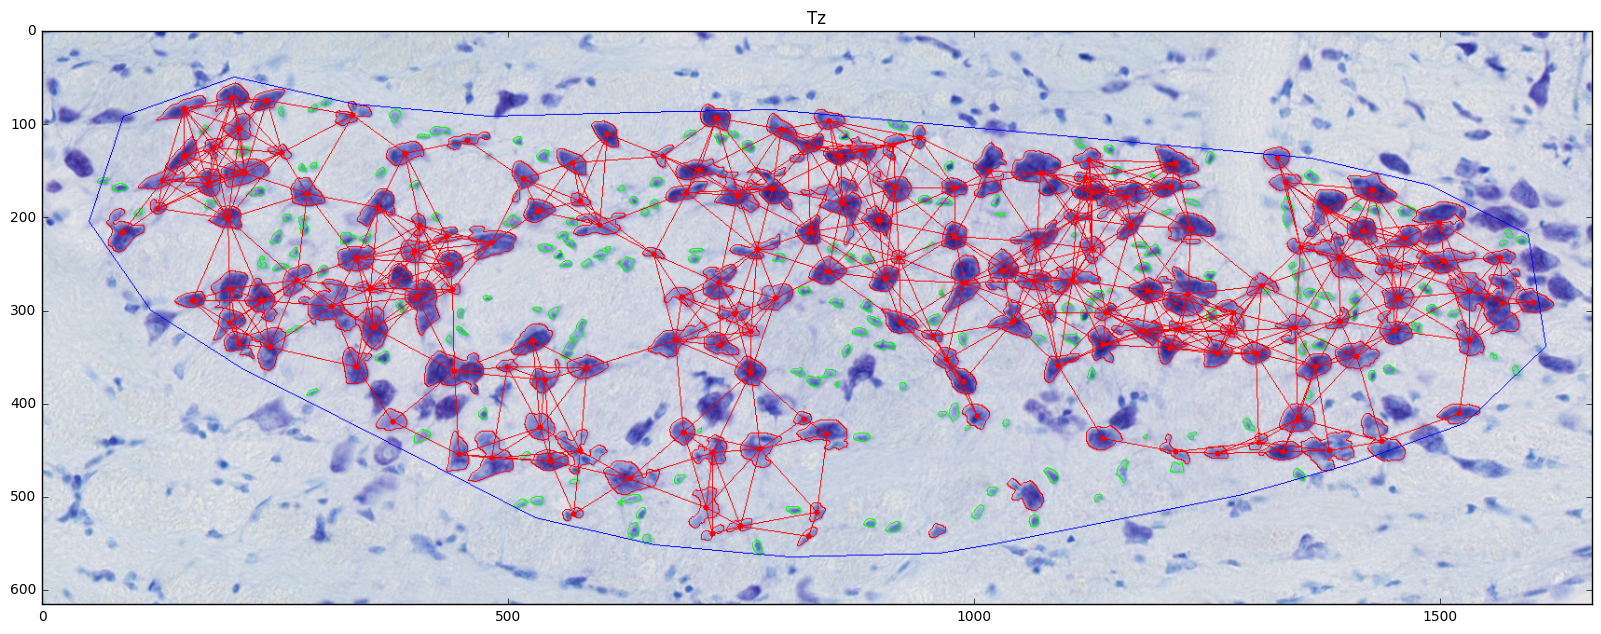

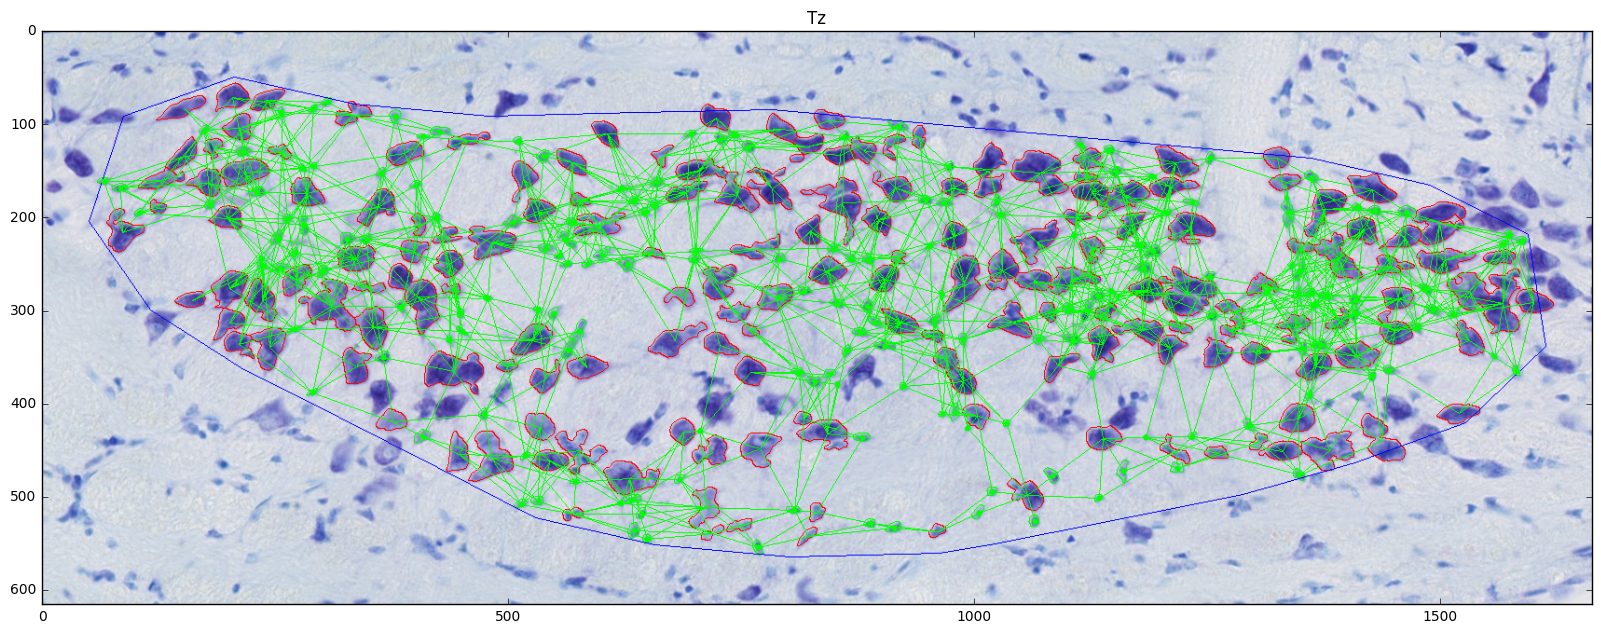

In [16]:
large_cell_centroids = cell_centroids[large_cell_indices]

# for name_u, cnt in contours.iteritems():
for name_u, cnt in [('Tz', contours['Tz'])]:

    # Get large cells

    large_cell_is_inside = Path(cnt.astype(np.int)).contains_points(large_cell_centroids)
    large_cell_indices_inside = large_cell_indices[large_cell_is_inside]

    print '%d large cells are identified in %s.' % (len(large_cell_indices_inside), name_u)

    # Small cells

    small_cell_indices = np.array(list(set(range(cell_numbers)) - set(large_cell_indices.tolist())))
    small_cell_centroids = cell_centroids[small_cell_indices]
    small_cell_is_inside = Path(cnt.astype(np.int)).contains_points(small_cell_centroids)
    small_cell_indices_inside = small_cell_indices[small_cell_is_inside]

    print '%d small cells are identified in %s.' % (len(small_cell_indices_inside), name_u)

    ##############################
    # Visualize
    ##############################

    viz = image.copy()

    # Draw large cell boundaries
    for i in large_cell_indices_inside:
        cv2.polylines(viz, [cell_contours_global[i].astype(np.int)], isClosed=True, color=(255,0,0), thickness=1)

    # Draw small cell boundaries
    for i in small_cell_indices_inside:
        cv2.polylines(viz, [cell_contours_global[i].astype(np.int)], isClosed=True, color=(0,255,0), thickness=1)

    # Draw structure boundary
    cv2.polylines(viz, [cnt.astype(np.int)], isClosed=True, color=(0,0,255), thickness=1)

    # Visualize radial-angular histogram of selected cells
    random_large_cell_indices = large_cell_indices_inside
#     random_large_cell_indices = np.random.choice(large_cell_indices_inside, 2, replace=False)

    for source in random_large_cell_indices:
        for i in neighbors[source]:
            
            # Draw link to large cells
            if i in large_cell_indices_inside:
                
                cv2.circle(viz, tuple(cell_centroids[i].astype(np.int)), 3, color=(255,0,0), thickness=-1)

                cv2.line(viz, tuple(cell_centroids[source].astype(np.int)), 
                     tuple(cell_centroids[i].astype(np.int)), 
                     color=(255,0,0), thickness=1)
                
#             # Draw link to small cells
#             if i in small_cell_indices_inside:
#                 cv2.circle(viz, tuple(cell_centroids[i].astype(np.int)), 3, color=(0,255,0), thickness=-1)            

#                 cv2.line(viz, tuple(cell_centroids[source].astype(np.int)), 
#                          tuple(cell_centroids[i].astype(np.int)), 
#                          color=(0,255,0), thickness=1)


#         # Draw radial bins
#         for rb in radial_bins:
#             cv2.circle(viz, tuple(cell_centroids[source].astype(np.int)), 
#                       int(rb), color=(0,0,255), thickness=1)

#         # Draw angular bins
#         for ab in angular_bins:
#             cv2.line(viz, tuple(cell_centroids[source].astype(np.int)), 
#                      tuple((cell_centroids[source] + (np.cos(ab)*100, np.sin(ab)*100)).astype(np.int)),
#              color=(0,0,255), thickness=1)


    # Find crop box

    margin = 50
    roi_xmin, roi_ymin = cnt.astype(np.int).min(axis=0) - margin
    roi_xmax, roi_ymax = cnt.astype(np.int).max(axis=0) + margin
#     print roi_xmin, roi_xmax, roi_ymin, roi_ymax

    plt.figure(figsize=(20, 20));
#     plt.title('%s, %s' % (name_u, random_large_cell_indices))
    plt.title('%s' % (name_u))
    plt.imshow(viz[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1]);
    plt.show();
    
    
    ####################################################################################
    
    viz = image.copy()

    # Draw large cell boundaries
    for i in large_cell_indices_inside:
        cv2.polylines(viz, [cell_contours_global[i].astype(np.int)], isClosed=True, color=(255,0,0), thickness=1)

    # Draw small cell boundaries
    for i in small_cell_indices_inside:
        cv2.polylines(viz, [cell_contours_global[i].astype(np.int)], isClosed=True, color=(0,255,0), thickness=1)

    # Draw structure boundary
    cv2.polylines(viz, [cnt.astype(np.int)], isClosed=True, color=(0,0,255), thickness=1)

    # Visualize radial-angular histogram of selected cells
    random_large_cell_indices = large_cell_indices_inside
#     random_large_cell_indices = np.random.choice(large_cell_indices_inside, 2, replace=False)

    for source in random_large_cell_indices:
        for i in neighbors[source]:
            
#             # Draw link to large cells
#             if i in large_cell_indices_inside:
                
#                 cv2.circle(viz, tuple(cell_centroids[i].astype(np.int)), 3, color=(255,0,0), thickness=-1)

#                 cv2.line(viz, tuple(cell_centroids[source].astype(np.int)), 
#                      tuple(cell_centroids[i].astype(np.int)), 
#                      color=(255,0,0), thickness=1)
                
            # Draw link to small cells
            if i in small_cell_indices_inside:
                cv2.circle(viz, tuple(cell_centroids[i].astype(np.int)), 3, color=(0,255,0), thickness=-1)            

                cv2.line(viz, tuple(cell_centroids[source].astype(np.int)), 
                         tuple(cell_centroids[i].astype(np.int)), 
                         color=(0,255,0), thickness=1)


#         # Draw radial bins
#         for rb in radial_bins:
#             cv2.circle(viz, tuple(cell_centroids[source].astype(np.int)), 
#                       int(rb), color=(0,0,255), thickness=1)

#         # Draw angular bins
#         for ab in angular_bins:
#             cv2.line(viz, tuple(cell_centroids[source].astype(np.int)), 
#                      tuple((cell_centroids[source] + (np.cos(ab)*100, np.sin(ab)*100)).astype(np.int)),
#              color=(0,0,255), thickness=1)


    # Find crop box

    margin = 50
    roi_xmin, roi_ymin = cnt.astype(np.int).min(axis=0) - margin
    roi_xmax, roi_ymax = cnt.astype(np.int).max(axis=0) + margin
#     print roi_xmin, roi_xmax, roi_ymin, roi_ymax

    plt.figure(figsize=(20, 20));
#     plt.title('%s, %s' % (name_u, random_large_cell_indices))
    plt.title('%s' % (name_u))
    plt.imshow(viz[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1]);
    plt.show();

In [ ]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in large_cell_size_histogram_all_regions.iteritems()},
                bins=size_bins[:-1],
               xlabel='Size (pixels)', 
                ylabel='Number of cells',
               suptitle='Histogram of LARGE cell size')

In [ ]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in all_cell_size_weighted_histogram_all_regions.iteritems()},
                bins=size_bins[:-1],
               xlabel='Size (pixels)', 
                ylabel='Number of cells',
               suptitle='WEIGHTED histogram of cell size')

In [ ]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in all_cell_size_histogram_all_regions.iteritems()},
                bins=size_bins[:-1],
               xlabel='Size (pixels)', 
                ylabel='Number of cells',
               suptitle='Histogram of cell size')

In [ ]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in large_cell_orientation_histogram_all_regions.iteritems()},
                bins=orientation_bins[:-1],
               xlabel='Orientation (radian)', 
                ylabel='Number of cells',
               suptitle='Histogram of LARGE cell orientation')

In [ ]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in neighbor_distance_histogram_all_regions.iteritems()},
                bins=edge_length_bins[:-1],
               xlabel='Neighbor distance (pixel)', 
                ylabel='Number of cells',
               suptitle='Histogram of neighbor distance')

In [ ]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in neighbor_direction_histogram_all_regions.iteritems()},
                bins=edge_direction_bins[:-1],
               xlabel='Neighbor direction (radian)', 
                ylabel='Number of cells',
               suptitle='Histogram of neighbor direction')

In [ ]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in large_cell_graph_neighbor_distance_histogram_all_regions.iteritems()},
                bins=edge_length_bins[:-1],
               xlabel='Neighbor distance (pixel)', 
                ylabel='Number of cells',
               suptitle='Histogram of neighbor distance for large cell graphs')

In [ ]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in large_cell_graph_neighbor_direction_histogram_all_regions.iteritems()},
                bins=edge_direction_bins[:-1],
               xlabel='Neighbor direction (radian)', 
                ylabel='Number of cells',
               suptitle='Histogram of neighbor direction for large cell graphs')

In [ ]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in large_small_cell_graph_neighbor_distance_histogram_all_regions.iteritems()},
                bins=edge_length_bins[:-1],
               xlabel='Neighbor distance (pixel)', 
                ylabel='Number of cells',
               suptitle='Histogram of neighbor distance for large-small cell graphs')

In [ ]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in large_small_cell_graph_neighbor_direction_histogram_all_regions.iteritems()},
                bins=edge_direction_bins[:-1],
               xlabel='Neighbor direction (radian)', 
                ylabel='Number of cells',
               suptitle='Histogram of neighbor direction for large-small cell graphs')